# <font color ='red'>Building a CNN Classifier for CIFAR10 dataset with ResNet50, VGG16,DenseNet121, EfficientNetB0, NASNetMobile</font>

In [2]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16, ResNet50, NASNetMobile, EfficientNetB0, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

## Download the CIFAR10 datasets 
Documentation for all tensorflow datasets: https://www.tensorflow.org/datasets 

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


In [4]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
from scipy import stats
data_analysis = stats.describe(x_train)
print(data_analysis[1][0][0][0][0])
print(data_analysis[1][1][0][0][0])

0
255


## Normalize the value

- Approach

    In image formats, pixel values are represented as integers ranging from 0 to 255. The value 0 represents the absence of color (black), while 255 represents the maximum intensity of color (white). By dividing the pixel values by 255, we scale them down to the range of 0 to 1, where 0 represents the minimum intensity (black) and 1 represents the maximum intensity (white).


- Alternative: MinMaxscaler

    When using MinMaxScaler, the original minimum and maximum values of the feature are transformed to the specified range. This can result in a different distribution of the data compared to dividing by 255. Dividing by 255 preserves the original distribution of the pixel values, which can be desirable for certain tasks.

In [6]:
# Normalize pixel values to be between 0 and 1 by dividing with 255
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
x_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

## Converting the target labels  into one-hot encoded format

Converting the label to the one-hot encoded labels is necessary for the model to learn the multi-class classification task accurately.

In [8]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Transfer learning with ResNet50, VGG16, InceptionV3, EfficientNetB0

Modules for transfer learning can be found on tensorflow applications website. https://www.tensorflow.org/api_docs/python/tf/keras/applications 

In [9]:
models = [ResNet50, VGG16,DenseNet121, EfficientNetB0, NASNetMobile]

## Transfer learning modules 

### Note: There is no ResNet52 in tensorflow application documentations. So, we proceeded to use base ResNet50 and explore the other models:

#### 1. ResNet50 (Residual Network 50):

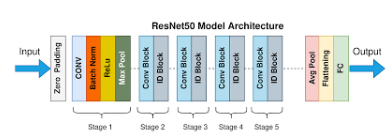

   ResNet50 is a convolutional neural network (CNN) architecture that consists of 50 layers. It introduced the concept of residual connections, which allow the network to learn residual mappings and alleviate the vanishing gradient problem. Residual connections enable the network to effectively train deeper architectures and have been widely used for various computer vision tasks.

#### 2. VGG16 (Visual Geometry Group 16):

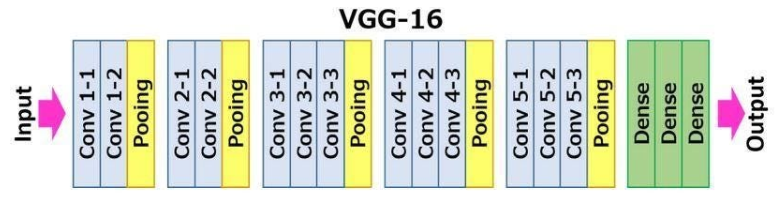

   VGG16 has 16 layers and is characterized by its simplicity and uniformity. VGG16 uses small 3x3 filters throughout the network and stacks multiple convolutional layers, followed by max-pooling layers. It has been widely used and serves as a benchmark for image classification tasks.

#### 3. DenseNet121 (Densely Connected Convolutional Network 121):

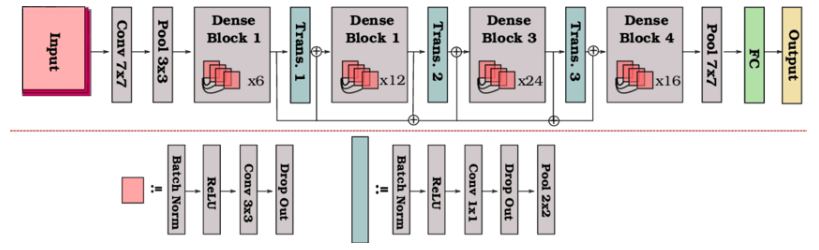

   DenseNet121 connects each layer to every other layer in a feed-forward manner, resulting in highly connected feature maps. DenseNet introduces the concept of dense blocks, where the outputs of previous layers are concatenated to the inputs of subsequent layers. This design allows for efficient information flow, gradient propagation, and feature reuse.

#### 4. EfficientNetB0:

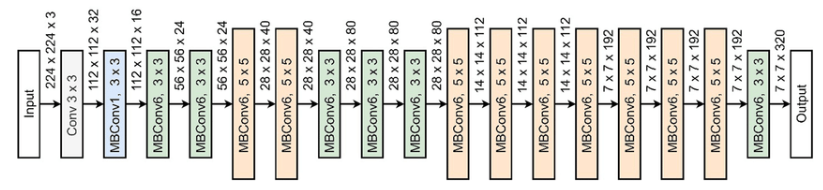

   EfficientNet models use a compound scaling method to balance network depth, width, and resolution, which enables them to achieve state-of-the-art performance while maintaining computational efficiency. The "B0" variant is the base model, and other variants like B1, B2, etc., increase in complexity. 

#### 5. NASNetMobile (Neural Architecture Search Network Mobile):

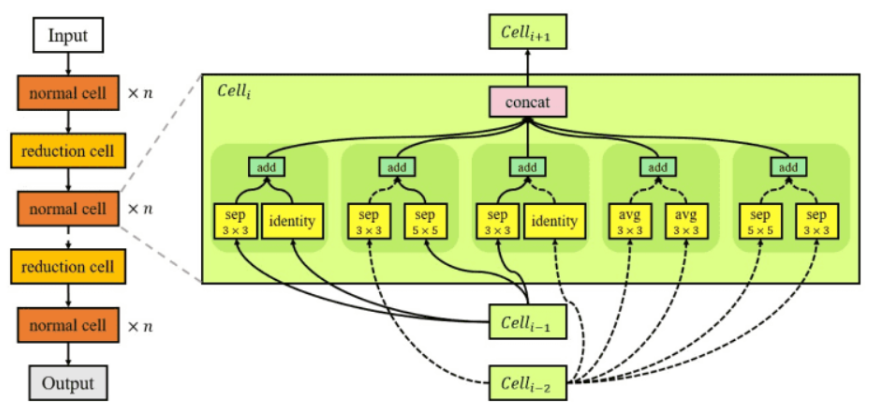

   NASNetMobile employs a cell-based architecture where the individual cells are designed through an automated search process. NASNetMobile is optimized for mobile and embedded devices, striking a balance between model size and performance. It has been trained on a large dataset and has shown strong performance on image classification tasks.
 

In [11]:
def model_evaluation(model_name, epoch_size):
    # Load pre-trained model without the top (fully connected) layers
    pretrained_model = model_name(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the layers of the pre-trained model
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Define the learning rate scheduler
    def learning_rate_scheduler(epoch):
        if epoch < epoch_size * 0.5:
            return 0.001
        elif epoch < epoch_size * 0.8:
            return 0.0001
        else:
            return 0.00001

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Train the model with learning rate scheduler
    print(f"\nTraining {model_name.__name__} model...")
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    summary = model.fit(x_train, y_train, batch_size=64, epochs=epoch_size, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    return summary

def plot_loss_vs_epoch(result, model_name):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [12]:
models = [ResNet50, VGG16,DenseNet121, EfficientNetB0, NASNetMobile]

In [13]:
model_name  = ["ResNet50" ,"VGG16","DenseNet121", "EfficientNetB0", "NASNetMobile"]

In [14]:
model_summary = []
for model in models:
    model_summary.append(model_evaluation(model,100))

94765736/94765736 [==============================] - 6s 0us/step

Training ResNet50 model...
Epoch 1/100
782/782 [==============================] - 26s 19ms/step - loss: 2.0612 - accuracy: 0.2530 - val_loss: 1.9225 - val_accuracy: 0.2817 - lr: 0.0010
Epoch 2/100
782/782 [==============================] - 13s 17ms/step - loss: 1.8813 - accuracy: 0.3164 - val_loss: 1.8624 - val_accuracy: 0.3314 - lr: 0.0010
Epoch 3/100
782/782 [==============================] - 13s 16ms/step - loss: 1.8283 - accuracy: 0.3402 - val_loss: 1.8318 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 4/100
782/782 [==============================] - 12s 16ms/step - loss: 1.7927 - accuracy: 0.3516 - val_loss: 1.7777 - val_accuracy: 0.3488 - lr: 0.0010
Epoch 5/100
782/782 [==============================] - 13s 17ms/step - loss: 1.7610 - accuracy: 0.3636 - val_loss: 1.7434 - val_accuracy: 0.3638 - lr: 0.0010
Epoch 6/100
782/782 [==============================] - 13s 16ms/step - loss: 1.7401 - accuracy: 0.3738 - val_loss: 1.

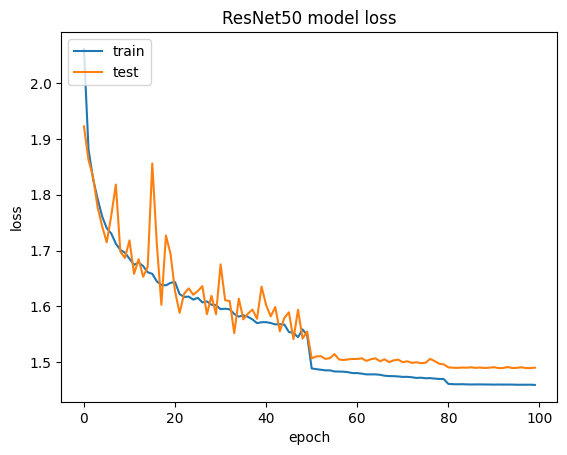

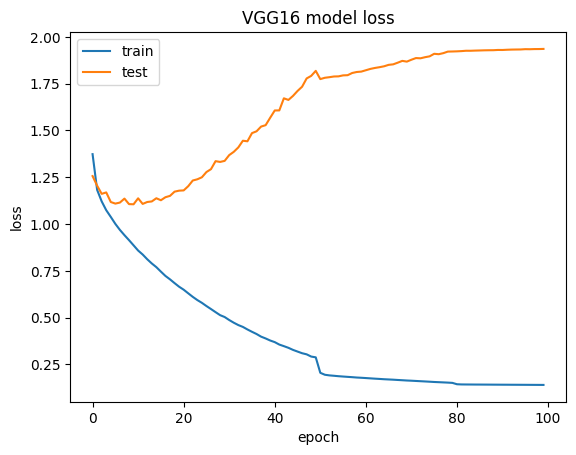

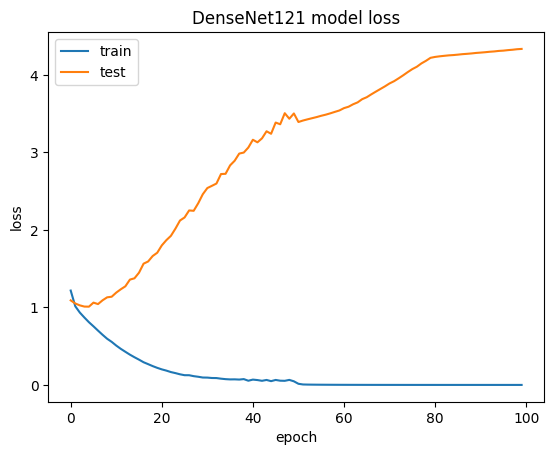

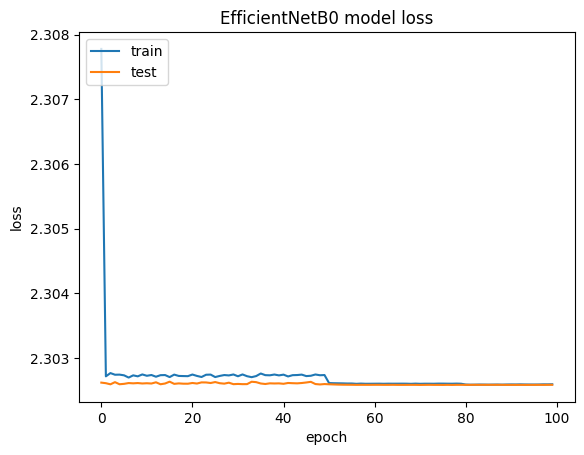

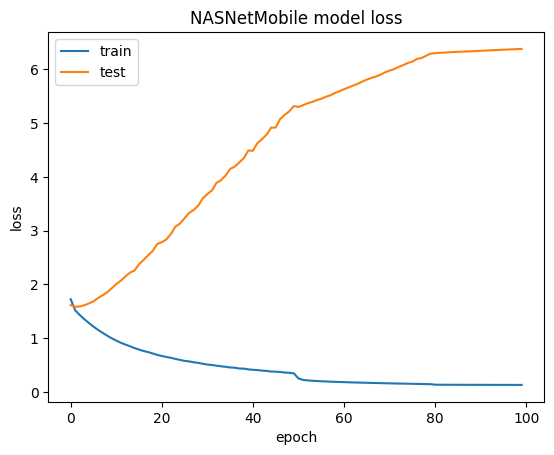

In [16]:
for summary,name in zip(model_summary,model_name):
    plot_loss_vs_epoch(summary,name)

In [45]:
import pandas as pd
def model_loss_accuracy(model):
  return model_summary[model].history["loss"][-1], model_summary[model].history["accuracy"][-1], model_summary[model].history["val_loss"][-1], model_summary[model].history["val_accuracy"][-1]
tuples = []
for i in range(len(model_summary)):
  tuples.append(model_loss_accuracy(i))
df = pd.DataFrame(tuples, columns=['Loss', 'Accuracy', 'Val_loss', 'Val_accuracy'], index = ["ResNet50" ,"VGG16","DenseNet121", "EfficientNetB0", "NASNetMobile"])
df

,Loss,Accuracy,Val_loss,Val_accuracy
ResNet50,1.459229,0.48652,1.490134,0.4696
VGG16,0.140526,0.97244,1.935371,0.6008
DenseNet121,0.000083,1.00000,4.335785,0.6300
EfficientNetB0,2.302594,0.09786,2.302586,0.1000
NASNetMobile,0.130502,0.97090,6.380982,0.3725


## Conclusion:

##### In our case, VGG16 performed well on the CIFAR-10 dataset. It has a simple and uniform architecture consisting of convolutional layers with small receptive fields (3x3 filters) followed by max-pooling layers. This structure effectively captures local and hierarchical features in the image, making it suitable for complex object recognition tasks. That being said, it is also worth noting that VGG16 is a fairly large model, and can be slow and computationally expensive to train.